<a href="https://colab.research.google.com/github/taunoe/jupyter-notebooks/blob/main/Pildid_sisendina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toetav praktiline näide loenguosale 3.1#
*Praktilise näite autor: Ardi Tampuu*

# Sissejuhatus

**Otusutusmets** on algoritm, mis koosneb mitmest otsususpuust. Otsustuspuudega tutvusime loengus. Metsas on otususpuid mitu ja igaüks neist on treenitud veidi erinevatel andmetel ja teatud määral juhuslikke otsuseid vastu võttes. Seega on iga puu veidi erinev. Otsustsusmets tervikuna toimib demokraatlikult, iga näite puhul ennustab iga puu, millisesse klassi antud näide kuuluda võiks. Ennustused kogutakse kokku ja mets annab vastusteks selle klassi, mida tema otsustuspuud enim õigeks vastuseks pidasid.

Otsustusmets on üldjuhul väga võimekas masinõppe algoritm. **Selles vihikus näitame aga, et otsustusmets saavutab sama ennustustäpsuse nii juhul, kui kasutada sisendina pilte nende normaalkujul, kui ka juhul, kui pildi pikslite väärtused niimoodi sassi ajada, et inimene enam pildist aru ei saaks.**

Otsustusmets, täissidusad tehisnärvivõrgud ja paljud teised masinõppe algoritmid näevad sisendit kui kogumikku üksteisest sõltumatuid tunnuseid. Et tunnused on sõltumatud, pole nende järjekord oluline ja võime järjekorra sassi ajada, ilma et mudeli võime erinevaid klasse eristada väheneks.

Järgnev koodikast impordib mõned vajalikud teegid (koodiraamatukogud), mis sisaldavad masinõppe algoritme ja jooniste tegemiseks vajalikke funktsioone. Samuti loeme oma vihikusse sisse andmed, mis pärinevad CIFAR10 andmestikust, mis sisaldab 32x32x3 suurusega värvilisi pilte kümnest erinevast klassist. 

In [1]:
# Esmalt laeme alla andmestiku ja impordime mõned kasulikud teegid


import keras #tehisnärvivõrkude teek. Siinkohal kasutame seda lihtsalt andmestiku alla laadimiseks
import numpy as np # arvutusliku Püütoni teek, võimaldab andmemassiividega toimetada
import matplotlib.pyplot as plt # graafikute, visualisatsioonide teek

# Cifar 10 andmestik on Kerase teegist lihtsasti kättesaadav
(train_img, train_label), (test_img, test_label) = keras.datasets.cifar10.load_data()
class_names = ['lennuk', 'auto', 'lind', 'kass', 'hirv', 'koer', 'konn', 'hobune', 'laev', 'veoauto']

170500096/170498071 [==============================] - 11s 0us/step


Nüüd on andmestik alla laetud. Treening- ja testandmed ning neile vastavad märgendid (õiged vastused) on salvestatud muutujatesse *train_img, test_img, test_label* ja *train_label*

Järgnev koodikast visualiseerib mõned pildid sellest andmestikust, et saaksite aimu, millised need pildid välja näevad.

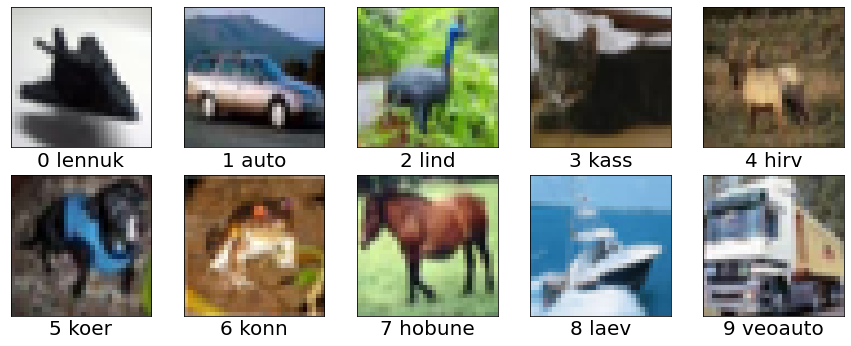

In [2]:
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    first_idx = np.argwhere(train_label==i)[0][0]
    plt.imshow(train_img[first_idx], cmap=plt.cm.binary)
    plt.xlabel(str(i)+" "+class_names[i],fontsize=20)
plt.show()

CIFAR10 pildid on küll udused, sest nad on ainult 32x32 pikslit suured, aga enamasti saab inimene aru, mis tüüpi objekt 10st võimalikust klassist on pildil.

Ka meie masinõppe mudelite eesmärk on mõista, mis on pildil. Saades sisendiks pildi, peab mudel ennustama, milline kümnest võimalikust objektist on pildil.

Selles vihikus ei ole meie eesmärk näidata, kui hea ennustusmudel on võimalik luua. Me soovime näidata, et teatud mudelid ei taju pilte samal viisil kui inimesed. Meie jaoks on oluline vaadata värve, piirjooni ja tekstuure erinevates pildiosades. Kõikide pikslite kõiki värviväärtusi iseseisvate tunnustena tajuvatel algoritmidel pole võimalik tajuda pildiosadi või naabrussuhteid pildiosade vahel. 

Järgneva koodikastiga tekitame alternatiivse andmestiku, kus ajame iga pildi pikslite väärtused segamini teatud reegli alusel. 


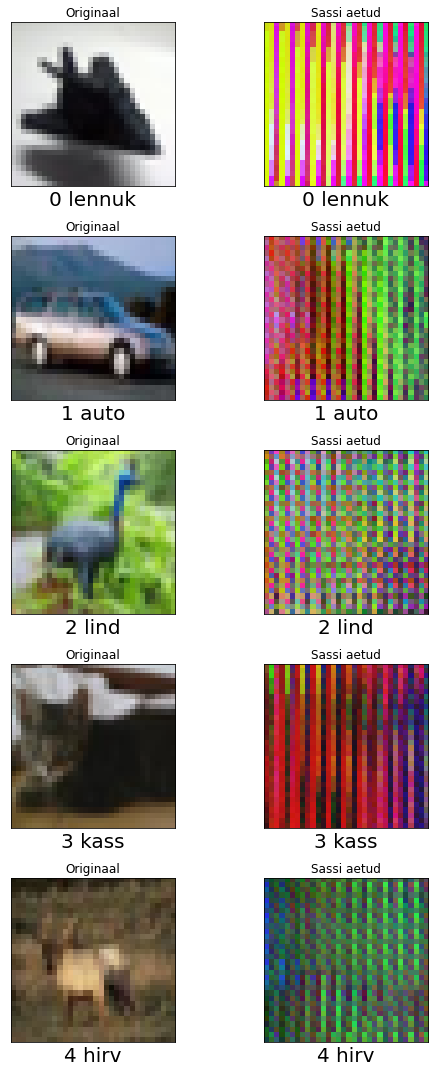

In [3]:
# Ajame kõikide pikslid sassi (aga sassi sama süsteemi järgi)
# 1) tasandades iga pildi
# 2) pannes pika vektori uuesti 32,32,3 kujule, aga täites 3D massiivi vales järjekorras
# s.t. mitte rida rea haaval, vaid värv-värvi haaval või veerg veeru haaval
train_img_flat = train_img.reshape((50000,32*32*3))
train_img_segamini = np.reshape(train_img_flat,(50000,32,32,3),order="F")



plt.figure(figsize=(8,15))
for i in range(5):
    plt.subplot(5,2,i*2+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Originaal")
    first_idx = np.argwhere(train_label==i)[0][0]
    plt.imshow(train_img[first_idx], cmap=plt.cm.binary)
    plt.xlabel(str(i)+" "+class_names[i],fontsize=20)

    plt.subplot(5,2,i*2+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Sassi aetud")

    first_idx = np.argwhere(train_label==i)[0][0]
    plt.imshow(train_img_segamini[first_idx], cmap=plt.cm.binary)
    plt.xlabel(str(i)+" "+class_names[i],fontsize=20)
plt.tight_layout()
plt.show()

Nüüd treenime esmalt otsustusmetsa mudeli originaalandmestikul.
Pane tähele, et otsustusmets võtab sisendid sisse ühe pika vektorina, seega tasandame (ingl. flatten) pildid pikkadeks vektoriteks

Meie otsustusmets koosneb 50st otsustuspuust. Treenime neid puid treeningandmetel. Et treenimine liigs kaua ei võtaks, oleme piiranud ka puude suurust (vt. teised parameetrid otsustusmetsa definitsioonis)

Järgnev koodikast loob otsustusmetsa (50 otsusutuspuud) ja treenib need 50000 treeningpilti ja märgendit kasutades. **Treenimine võib võtta mõned minutid aega**

In [4]:
from sklearn.ensemble import RandomForestClassifier 

# Esmalt treenime 100 puuga otsustusmetsa CIFAR10 andemtel nende originaalkujul
RF_model= RandomForestClassifier(n_estimators=50,n_jobs=2, max_depth=20,min_samples_split=8)
RF_model.fit(train_img.reshape((50000,32*32*3)), train_label.flatten())

print("mudel on nüüd treenitud, võid järgmise koodikasti käivitada")

mudel on nüüd treenitud, võid järgmise koodikasti käivitada


Nüüd treenime 50 puuga otsustusmetsa mudeli sassi aetud andmestikul.

**Treenimine võib võtta mõned minutid aega**

In [5]:
#Treenime ka otsustusmetsa veidi sassi aetud andmetel
RF_model_segamini= RandomForestClassifier(n_estimators=50,n_jobs=2,max_depth=20,min_samples_split=8)
RF_model_segamini.fit(train_img_segamini.reshape((50000,32*32*3)), train_label.flatten())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Lõpuks testime (valideerime) mõlemat mudelit. Esimest mudelit algsel testandmestikul ja sassi aetud andmete mudelit sassi aetud testandmetel

In [6]:
print("Normaalsetel piltidel treenitud mudeli keskmine täpsus on: ",RF_model.score(test_img.reshape((10000,32*32*3)), test_label))

#ajame ka testandmed sarnaselt sassi
test_img_flat = test_img.reshape((10000,32*32*3))
test_img_segamini = np.reshape(test_img_flat,(10000,32,32,3),order="F")

print("\n\nSegamini aetud väärtustega piltidel treenitud mudeli täpsus \n (kasutades samal viisil sassi aetud test-andmeid), on: ", RF_model_segamini.score(test_img_segamini.reshape((10000,32*32*3)), test_label))

Normaalsetel piltidel treenitud mudeli keskmine täpsus on:  0.4554


Segamini aetud väärtustega piltidel treenitud mudeli täpsus 
 (kasutades samal viisil sassi aetud test-andmeid), on:  0.4493


# KOKKUVÕTE

Treenisime otsustusmetsa, mis sai sisendiks pildid nende tasandatud kujul. See võrk saavutas test-piltidel umbes 46% täpsuse (täpsuse väärtus sõltub veidi ka juhuslikkusest)

Seejärel ajasime treening- ja testandmestiku piltide pikslite väärtused nii põhjalikult sassi, et inimene enam pildist aru ei saa. Algse pildi 32 korda 32 korda 3 väärtust on ikkagi kõik olemas, aga sellises järjekorras, et pildina esitades ei kujuta see enam midagi.

**Sellegipoolest saavutas ka sellel andmestikul treenitud otsustusmets testandmetel sama täpsuse!** (ka testandmestik oli samal viisil sassi aetud)

Seega leidis kinnitust meie algne väide, et mudelid, mis käsitlevad sisendeid kui pikka vektorit üksteisest sõltumatuid tunnuseid, ei hooli pildi strukturist ja naabrussuhetest pikslite vahel.

<br>
<br>


Kuigi see pole otseselt selle vihiku eesmärk, siis võime küsida ka, **miks on otsustusmetsa mudelite täpsus nii madal?** Esimene viis selle diagnoosimiseks on vaadata täpsust treeningandmetel - kui täpsus on ka seal sama madal, on mudel alasobitunud, kui mudel on treeningandmetel täpne, on tegu ülesobitumisega. Järgnev koodikast arvutab meie kahe mudeli treeningtäpsused.


In [7]:
print("Normaalsetel piltidel treenitud mudeli keskmine treening-täpsus on: ",RF_model.score(train_img.reshape((50000,32*32*3)), train_label))
print("Sassiaetud piltidel treenitud mudeli keskmine treening-täpsus on: ",RF_model_segamini.score(train_img_segamini.reshape((50000,32*32*3)), train_label))


Normaalsetel piltidel treenitud mudeli keskmine treening-täpsus on:  0.9917
Sassiaetud piltidel treenitud mudeli keskmine treening-täpsus on:  0.99164


Nagu näeme, on mõlemad mudelid treeningandmetel ülimalt täpsed. Need mudelid on tugevalt ülesobitunud, vaatamata sellele, et piirasime otsustusmetsa puude suurust (ehk seda, kui mitmest otsusest nad koosneda saavad).